In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score

# Weight of Evidence - Feature Selection
from xverse.transformer import WOE

# The notebook is divided into following parts:

    1. Data import
    2. EDA
    3. Modeling on raw data
        3.1 Features : all features
        3.2 Feature selection and then modeling
        3.3 Fltering using account_id
        3.4 Test Train Sampling based on account_id
        3.4 Incorporating week_date into model
    4. Takeaways
    5. Feature Engineering
    6. Clustering and Classication
        6.1 Clustering based on features (relations between model)
        6.2 Classification based on features+clusters are independent variable and Label as dependent variable   

# 1. Data Import

In [2]:
# Read Training and test sets
train_data = pd.read_csv('Train_Set.csv')
test_data = pd.read_csv('Test_Set.csv')

In [3]:
len(test_data.account_id.unique())

713

In [4]:
len(set(test_data['account_id']) - set(train_data['account_id']))

603

In [5]:
train_data['week_start_date'] = pd.to_datetime(train_data['week_start_date'], format='%m/%d/%Y', errors='ignore')
test_data['week_start_date'] = pd.to_datetime(test_data['week_start_date'], format='%m/%d/%Y', errors='ignore')

In [6]:
sum(train_data.groupby(['account_id', 'week_start_date'])['feature1'].count() > 1)

18945

- Approx. 19k duplicate values

In [7]:
# Removing duplicate rows
train_data.drop_duplicates(keep = 'first', inplace = True)

In [99]:
test_data.head()

,account_id,week_start_date,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
0,105049,2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,105049,2018-09-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,105049,2018-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,105049,2018-09-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,105049,2018-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [100]:
test_data.shape

(29620, 65)

In [102]:
test_data.drop_duplicates(keep = 'first', inplace = True)

In [103]:
test_data.shape

(27693, 65)

In [8]:
train_data['Label'].value_counts(normalize = True)

0    0.993035
1    0.006965
Name: Label, dtype: float64

- 603 new accounts in test data

# 2. EDA

In [9]:
train_data['Label'].value_counts(normalize=True)

0    0.993035
1    0.006965
Name: Label, dtype: float64

In [10]:
test_data['Label'].value_counts(normalize=True)

0    0.990648
1    0.009352
Name: Label, dtype: float64

In [11]:
train_data.head()

,account_id,week_start_date,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
0,100559.0,2018-09-03,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,101026.0,2018-09-03,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,101026.0,2018-09-10,0.0,0.0,86.666667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,101026.0,2018-09-17,0.0,0.0,-0.076046,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,101026.0,2018-09-24,0.0,0.0,-0.987654,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
n_row, n_col = train_data.shape
n_row, n_col

(93175, 65)

- n_rows = 93175
- n_cols = 65

In [13]:
train_data.describe()

,account_id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
count,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,...,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000,93175.000000
mean,133995.894285,0.004556,0.000312,1.359866,0.000058,0.000051,0.001871,0.014587,0.000278,0.026780,...,0.000730,0.050951,0.018393,0.000104,0.028186,0.003016,0.002903,0.001772,0.046110,0.006965
std,42988.942443,0.122827,0.047580,15.638121,0.011410,0.010946,0.107718,0.537802,0.026331,1.931629,...,0.117225,0.588272,0.856218,0.016880,0.827953,0.147153,0.130436,0.119347,1.902486,0.083168
min,100000.000000,-0.894737,-0.705882,-0.999442,-0.500000,-0.500000,-0.916667,-0.992701,-0.700000,-0.998079,...,-0.782609,-0.975000,-0.993750,-0.750000,-0.989455,-0.926471,-0.989691,-0.907514,-0.996314,0.000000
25%,101604.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,105501.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,180591.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,239955.000000,10.012658,12.000000,1792.000000,1.000000,1.000000,20.000000,87.000000,2.333333,519.500000,...,33.951456,48.206349,159.000000,3.000000,108.000000,21.000000,19.250000,23.800000,445.500000,1.000000


- Most of the values are 0
- mean value for columns (Except account, date, label) are not 0 where as median and 75% values are 0
- values are susceptible to outliers
- Feature Engineering - Scaling of variables

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93175 entries, 0 to 114705
Data columns (total 65 columns):
account_id         93175 non-null float64
week_start_date    93175 non-null object
feature1           93175 non-null float64
feature2           93175 non-null float64
feature3           93175 non-null float64
feature4           93175 non-null float64
feature5           93175 non-null float64
feature6           93175 non-null float64
feature7           93175 non-null float64
feature8           93175 non-null float64
feature9           93175 non-null float64
feature10          93175 non-null float64
feature11          93175 non-null float64
feature12          93175 non-null float64
feature13          93175 non-null float64
feature14          93175 non-null float64
feature15          93175 non-null float64
feature16          93175 non-null float64
feature17          93175 non-null float64
feature18          93175 non-null float64
feature19          93175 non-null float64
feature20

- No null values

In [15]:
train_data['Label'].value_counts(normalize = True)

0    0.993035
1    0.006965
Name: Label, dtype: float64

Data is highly skewed
- 1: 0.6%
- 0: 99.3%

In [16]:
train_data['Label'].value_counts()

0    92526
1      649
Name: Label, dtype: int64

In [17]:
train_data['account_id'].value_counts()

100583.0    134
100162.0    133
100746.0    133
101799.0    132
105810.0    126
           ... 
187622.0      1
100559.0      1
105388.0      1
100796.0      1
239955.0      1
Name: account_id, Length: 2690, dtype: int64

In [18]:
# feature interaction
features = ['feature'+str(i) for i in range(1,63)]

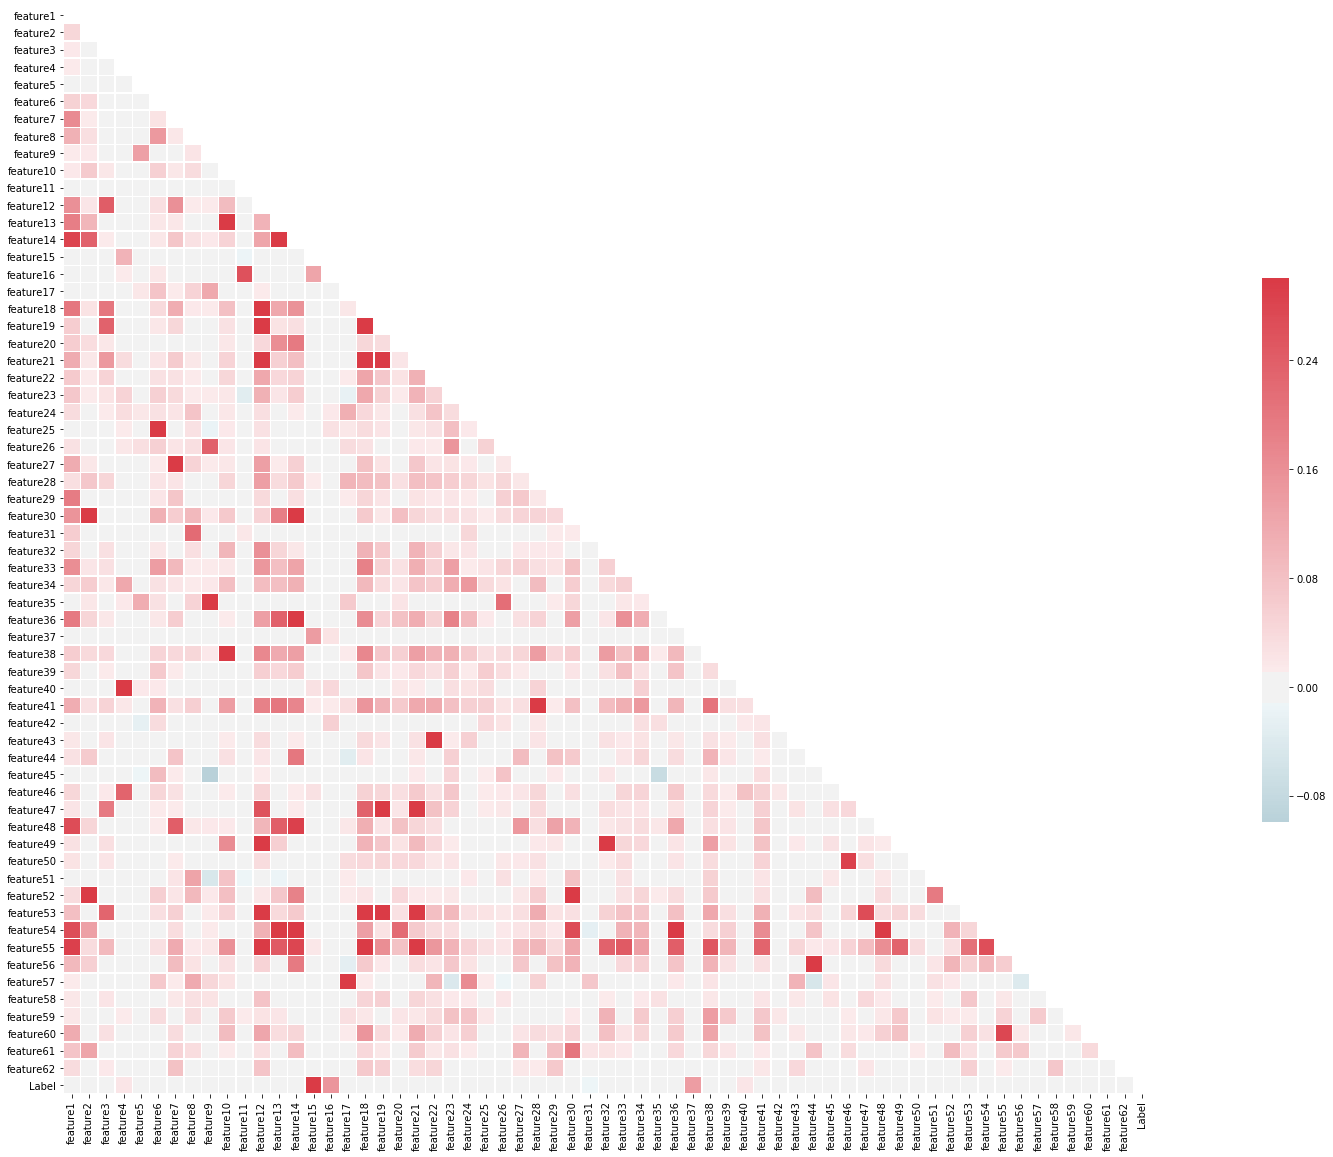

In [19]:
# Compute the correlation matrix
corr = train_data[features + ['Label']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt = '0.1f')
plt.show()



- Correlation is present among the features

In [20]:
corr

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
feature1,1.000000,0.042986,0.015031,0.011799,-0.000248,0.052856,0.166752,0.107994,0.013533,0.014932,...,0.268574,0.289057,0.091728,0.012272,0.017595,0.018964,0.113698,0.074381,0.035557,-0.003219
feature2,0.042986,1.000000,0.000985,-0.000033,-0.000030,0.041615,0.013757,0.032099,0.015483,0.061593,...,0.131729,0.037754,0.054821,-0.004495,0.000066,0.001894,0.003380,0.125495,0.000071,-0.000549
feature3,0.015031,0.000985,1.000000,0.003608,-0.000100,0.009440,0.004267,0.002428,0.002205,0.017452,...,0.008552,0.091805,0.003821,0.002082,0.020899,0.005089,0.028879,0.004089,0.015464,0.000960
feature4,0.011799,-0.000033,0.003608,1.000000,-0.000024,0.005714,-0.000139,-0.000054,0.002632,-0.000094,...,-0.000032,-0.006003,-0.001083,-0.003747,0.002160,0.014354,0.001138,-0.000076,0.001453,0.020874
feature5,-0.000248,-0.000030,-0.000100,-0.000024,1.000000,-0.000037,-0.000126,-0.000049,0.131861,-0.000085,...,-0.000029,0.009658,0.000166,-0.000028,0.006158,-0.003426,-0.000103,-0.000069,-0.000308,-0.000388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature59,0.018964,0.001894,0.005089,0.014354,-0.003426,0.037966,0.002336,0.037095,-0.001146,0.063869,...,-0.001637,0.049629,0.001207,0.061881,0.005165,1.000000,0.016394,0.003951,0.006146,-0.002330
feature60,0.113698,0.003380,0.028879,0.001138,-0.000103,0.003922,0.036800,-0.000889,0.005896,0.086575,...,0.026442,0.277786,0.016572,0.000838,0.006102,0.016394,1.000000,0.038888,0.004462,0.003978
feature61,0.074381,0.125495,0.004089,-0.000076,-0.000069,-0.003086,0.049050,0.034254,0.006394,0.013034,...,0.011196,0.065869,0.067209,-0.002163,-0.001197,0.003951,0.038888,1.000000,-0.000408,-0.000973
feature62,0.035557,0.000071,0.015464,0.001453,-0.000308,0.003828,0.077089,0.007983,0.004036,0.004056,...,-0.000122,0.013422,0.001927,0.008944,0.067935,0.006146,0.004462,-0.000408,1.000000,-0.001908


In [21]:
train_data_one = train_data[train_data['Label'] == 1]

In [22]:
train_data_one.shape

(649, 65)

In [23]:
train_data_one['feature_sum'] = train_data_one[features].sum(axis = 1)

In [24]:
sum(train_data_one['feature_sum'] == 0)

190

In [25]:
train_data_zero = train_data[train_data['Label'] == 0]

In [26]:
train_data_zero['feature_sum'] = train_data_zero[features].sum(axis = 1)

In [27]:
sum(train_data_zero['feature_sum'] > 0)

28378

In [28]:
train_data_zero.shape

(92526, 66)

In [29]:
# features with all value zero
sum(train_data.sum(axis = 0) == 0)

0

# 3. Modeling on raw data

In [116]:
# Creating function training the data on multiple algorithms
def trainData(X_train, X_test, y_train, y_test):

    '''
    Function to train the model on training sets
    
    input: X_test, X_train, y_train, y_test
    output: models (svc, log_reg, d_tree, rf)
    '''
    # SVM
    # instantiate
    svc = LinearSVC(max_iter = 3000)
    # fit
    svc.fit(X_train, y_train)


    # Logistic
    # instantiate
    log_reg = LogisticRegression(max_iter = 2000)
    # fit
    log_reg.fit(X_train, y_train)

    # Decision Tree
    # instantiate
    d_tree = DecisionTreeClassifier()
    # fit
    d_tree.fit(X_train, y_train)


    # Random Forest
    # instantiate
    rf = RandomForestClassifier()
    # fit
    rf.fit(X_train, y_train)
    
    return svc, log_reg, d_tree, rf

In [147]:
# Creating a function to plot precision_recall curve
def plot_curve(ax, X_test, y_test):
    plot_precision_recall_curve(svc, X_test, y_test, ax = ax)
    plot_precision_recall_curve(log_reg, X_test, y_test, ax = ax)
    plot_precision_recall_curve(d_tree, X_test, y_test, ax = ax)
    plot_precision_recall_curve(rf, X_test, y_test, ax = ax)
    plt.legend(loc='best', prop={'size': 10})
    
    return

   ## 3.1 Without Feature Selection

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

No handles with labels found to put in legend.


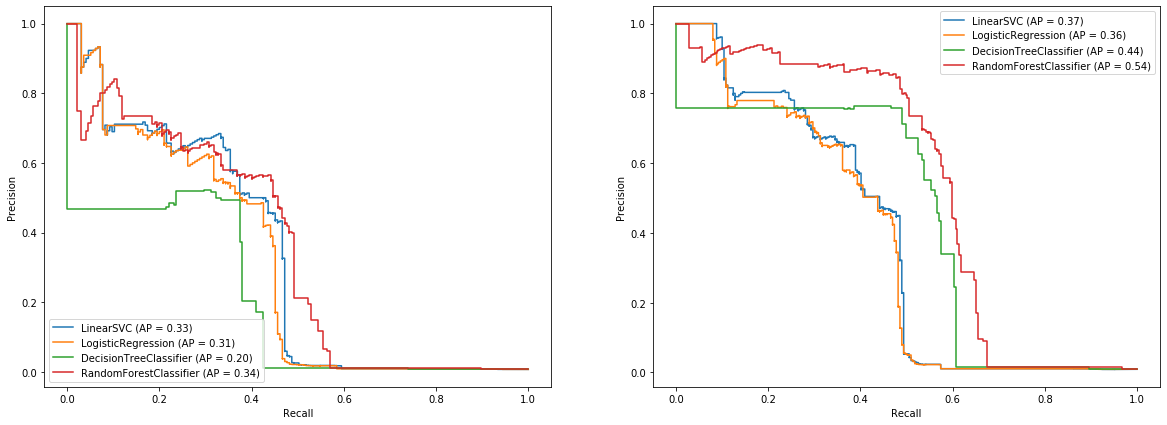

In [150]:
X=train_data[features]
y=train_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

svc, log_reg, d_tree, rf = trainData(X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_curve(ax = ax[0], X_test = X_test, y_test=y_test)

# Visualizing results on test_data
X_test, y_test = test_data[features], test_data['Label']
plot_curve(ax = ax[1], X_test = X_test, y_test=y_test)
plt.show()

- The perfomance of `SVM` and `Logistic regression` is way below `Random Forest`
- The model is built using raw features (without scaling). 
- Since SVM and Logistic Regression algorithms work on distance, therefore the perfomance of both the algorithms are low

## 3.2 Feature Selection

- For feature selection, I am using **WOE (Weight of Evidence)** and **Information Value** of features.
- Based on information value, I will be choosing features

**selecting important features from feature1 .... feature62**

In [36]:
X = train_data[features]

# instantiate
clf = WOE()

# fit
clf.fit(X,y)

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning:

divide by zero encountered in log



WOE(exclude_features=None, feature_names='all', mono_cardinality_cutoff=5,
    mono_custom_binning={'feature1': array([-0.89473684,  0.        , 10.01265823]),
                         'feature10': array([-0.87209302,  0.        , 18.        ]),
                         'feature11': array([-0.5,  0. ,  1. ]),
                         'feature12': array([-0.9875,  0.    , 79.    ]),
                         'feature13': array([-0.8125,  0.    , 20.    ]),
                         'feature14': array([-0.90909091,  0.        , 67.28947368]),
                         'feature15': array(...
              'feature34': {Interval(-0.921, 0.0, closed='right'): 0.006335368125314215,
                            Interval(0.0, 11.5, closed='right'): -0.3390049932080663},
              'feature35': {Interval(-0.883, 0.0, closed='right'): 0.0011246405580134268,
                            Interval(0.0, 7.5, closed='right'): 0.0},
              'feature36': {Interval(-0.983, 0.0, closed='right'): 0.02

In [37]:
# WOE : Weight Of Evidence Dataset
clf.woe_df

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,feature1,"(-0.896, 0.0]",91501,644,90857,0.007038,0.992962,0.992296,0.981962,0.010469,0.008900
1,feature1,"(0.0, 10.013]",1674,5,1669,0.002987,0.997013,0.007704,0.018038,-0.850730,0.008900
2,feature10,"(-0.873, 0.0]",92279,646,91633,0.007001,0.992999,0.995378,0.990349,0.005065,0.003728
3,feature10,"(0.0, 18.0]",896,3,893,0.003348,0.996652,0.004622,0.009651,-0.736162,0.003728
4,feature11,"(-0.501, 0.0]",93138,639,92499,0.006861,0.993139,0.984592,0.999708,-0.015236,0.060191
...,...,...,...,...,...,...,...,...,...,...,...
119,feature7,"(0.0, 87.0]",2176,2,2174,0.000919,0.999081,0.003082,0.023496,-2.031365,0.041892
120,feature8,"(-0.701, 0.0]",93002,649,92353,0.006978,0.993022,1.000000,0.998130,0.001871,0.000003
121,feature8,"(0.0, 2.333]",173,0,173,0.000000,1.000000,0.000000,0.001870,0.000000,0.000003
122,feature9,"(-0.999, 0.0]",89917,646,89271,0.007184,0.992816,0.995378,0.964821,0.031180,0.062968


In [38]:
# IV : Information Value dataset
clf.iv_df.sort_values(by='Information_Value', ascending=False)

,Variable_Name,Information_Value
6,feature15,2.344675e+00
30,feature37,5.806562e-01
3,feature12,3.435444e-01
7,feature16,3.179174e-01
41,feature47,3.143082e-01
...,...,...
11,feature2,6.749600e-07
46,feature51,1.272266e-07
36,feature42,7.301484e-08
44,feature5,6.179909e-08


### Handy rule for Information Value

    +-------------------+-----------------------------+
    | Information Value | Variable Predictiveness     |
    +-------------------+-----------------------------+
    | Less than 0.02    | Not useful for prediction   |
    +-------------------+-----------------------------+
    | 0.02 to 0.1       | Weak predictive Power       |
    +-------------------+-----------------------------+
    | 0.1 to 0.3        | Medium predictive Power     |
    +-------------------+-----------------------------+
    | 0.3 to 0.5        | Strong predictive Power     |
    +-------------------+-----------------------------+
    | >0.5              | Suspicious Predictive Power |
    +-------------------+-----------------------------+



In [39]:
sel_feature_IV = clf.iv_df[clf.iv_df['Information_Value'] >= 0.02].sort_values(by = 'Information_Value', ascending  = False)
print(sel_feature_IV)
selected_features = sel_feature_IV['Variable_Name'].values
print(sel_feature_IV['Variable_Name'].values)

   Variable_Name  Information_Value
6      feature15           2.344675
30     feature37           0.580656
3      feature12           0.343544
7      feature16           0.317917
41     feature47           0.314308
9      feature18           0.307741
10     feature19           0.297798
13     feature21           0.291518
48     feature53           0.201524
15     feature23           0.105649
22      feature3           0.071745
61      feature9           0.062968
32     feature39           0.060786
2      feature11           0.060191
59      feature7           0.041892
29     feature36           0.037886
31     feature38           0.037713
19     feature27           0.036172
5      feature14           0.027335
51     feature56           0.022304
25     feature32           0.020842
43     feature49           0.020746
['feature15' 'feature37' 'feature12' 'feature16' 'feature47' 'feature18'
 'feature19' 'feature21' 'feature53' 'feature23' 'feature3' 'feature9'
 'feature39' 'feature11' 'fe

- `feature15` with IV = 2.3 (suspicious)

In [40]:
selected_features

array(['feature15', 'feature37', 'feature12', 'feature16', 'feature47',
       'feature18', 'feature19', 'feature21', 'feature53', 'feature23',
       'feature3', 'feature9', 'feature39', 'feature11', 'feature7',
       'feature36', 'feature38', 'feature27', 'feature14', 'feature56',
       'feature32', 'feature49'], dtype=object)

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

No handles with labels found to put in legend.


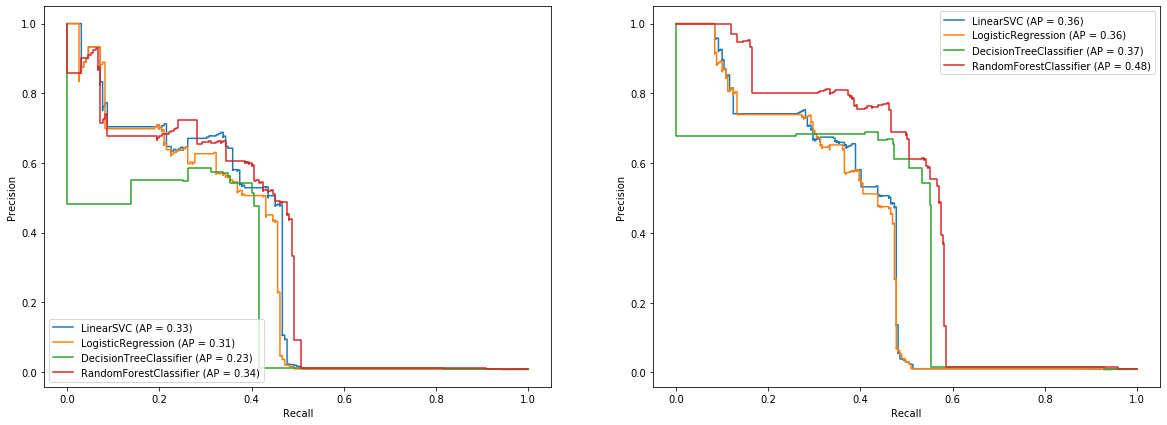

In [152]:
X=train_data[selected_features]
y=train_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

svc, log_reg, d_tree, rf = trainData(X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_curve(ax = ax[0], X_test = X_test, y_test=y_test)

# Visualizing results on test_data
X_test, y_test = test_data[selected_features], test_data['Label']
plot_curve(ax = ax[1], X_test = X_test, y_test=y_test)
plt.show()

- Feature selection do not have any affect on `SVM`,`Logistic` and `Random Forest`
- The Average precision value of `Decision Tree` has increased slightly

## 3.3 Filtering using `account_id`

In [47]:
# Removing the accounts for which the Label is always 0
train_data_acc = train_data[train_data['account_id'].map(train_data.groupby('account_id')['Label'].sum()) > 0].reset_index(drop = True)
train_data_acc.shape

(28749, 65)

In [48]:
train_data_acc['Label'].value_counts(normalize = True)

0    0.977425
1    0.022575
Name: Label, dtype: float64

In [49]:
train_data_acc['Label'].value_counts()

0    28100
1      649
Name: Label, dtype: int64

- More than 50% of the rows are eliminated (Accounts with all 0 labels are removed)

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

No handles with labels found to put in legend.


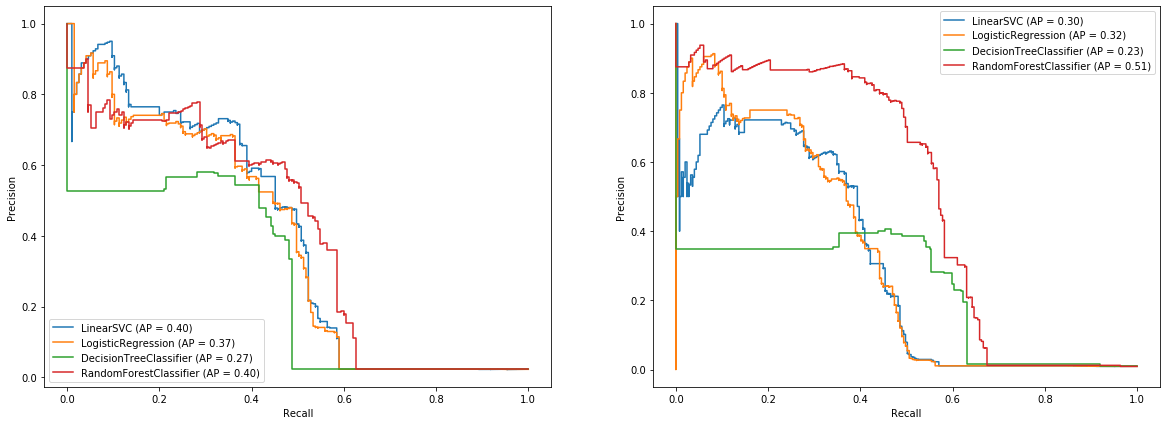

In [153]:
X=train_data_acc[features]
y=train_data_acc['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

svc, log_reg, d_tree, rf = trainData(X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_curve(ax = ax[0], X_test = X_test, y_test=y_test)

# Visualizing results on test_data
X_test, y_test = test_data[features], test_data['Label']
plot_curve(ax = ax[1], X_test = X_test, y_test=y_test)
plt.show()

- Average precision scores of all the algorithms have increased

## 3.4 Test Train Sampling based on `account_id`

In [53]:
train, test = np.split(train_data_acc, [int(.7*len(train_data_acc))])

In [54]:
train.shape, test.shape

((20124, 65), (8625, 65))

In [55]:
train['Label'].value_counts(normalize=True)

0    0.977639
1    0.022361
Name: Label, dtype: float64

In [56]:
test['Label'].value_counts(normalize=True)

0    0.976928
1    0.023072
Name: Label, dtype: float64

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

No handles with labels found to put in legend.


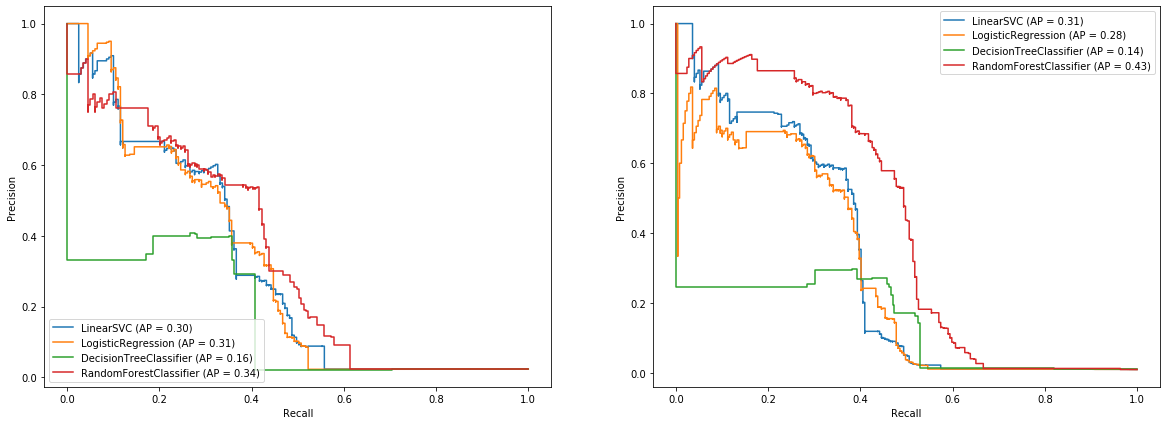

In [154]:
X_train, X_test, y_train, y_test = train[features], test[features], train['Label'], test['Label']
X_train.shape, X_test.shape, y_train.shape, y_test.shape

svc, log_reg, d_tree, rf = trainData(X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_curve(ax = ax[0], X_test = X_test, y_test=y_test)

# Visualizing results on test_data
X_test, y_test = test_data[features], test_data['Label']
plot_curve(ax = ax[1], X_test = X_test, y_test=y_test)
plt.show()

- The precisions scores have decreased
- Interesting to see how feature selection affect the Precision recall curve

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

No handles with labels found to put in legend.


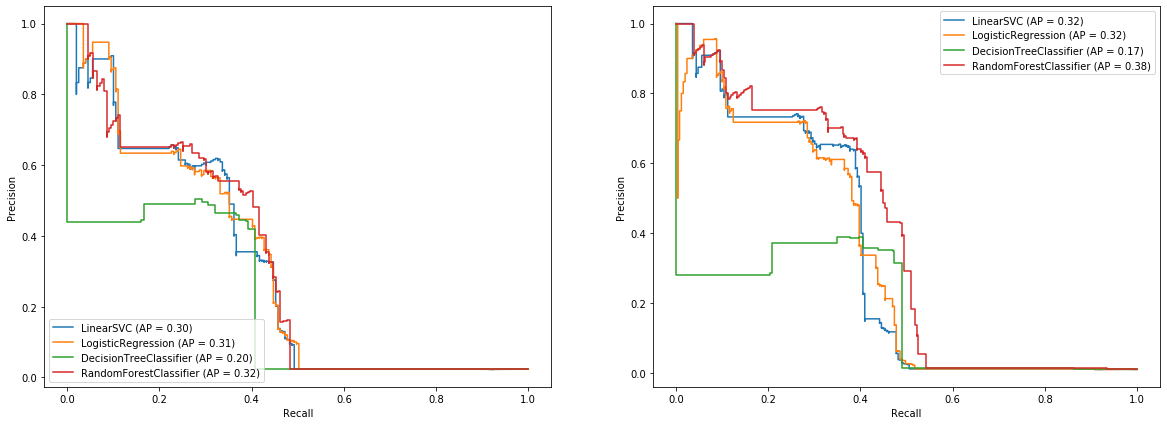

In [156]:
# Running the model on selected features
X_train, X_test, y_train, y_test = train[selected_features], test[selected_features], train['Label'], test['Label']
X_train.shape, X_test.shape, y_train.shape, y_test.shape

svc, log_reg, d_tree, rf = trainData(X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_curve(ax = ax[0], X_test = X_test, y_test=y_test)

# Visualizing results on test_data
X_test, y_test = test_data[selected_features], test_data['Label']
plot_curve(ax = ax[1], X_test = X_test, y_test=y_test)
plt.show()

- Not much affect

**Conclusion** : Keep all the features as models have not shown any significant increase using Feature selection

## 3.5 Incorporating `week_date` into model

As discussed over Zoom call, there is a particular threshold at which after which the `account` toggles its `Label` value

![title](img/account_threshold.png)

- Filtering the dataset in such a way that pairs of `(0,1)` Target variable(`Label`) is captured
- Each (0,1) pair is taken as sequence
- After doing this exercise, we will have equal number of 0s and equal number of 1s

In [64]:
train_data['account_id'].value_counts()

100583.0    134
100162.0    133
100746.0    133
101799.0    132
105810.0    126
           ... 
187622.0      1
100559.0      1
105388.0      1
100796.0      1
239955.0      1
Name: account_id, Length: 2690, dtype: int64

In [94]:
unique_accounts = train_data_acc['account_id'].unique()
df_outer = pd.DataFrame()
for acc in unique_accounts:
    df = train_data_acc[train_data_acc['account_id'] == acc]
    df['g'] = df['Label'].ne(df['Label'].shift()).cumsum()
    df.drop_duplicates('g', keep = 'last', inplace = True)
    if df.shape[0] % 2 == 1:
        df_outer = df_outer.append(df[:-1])
    else:
        df_outer = df_outer.append(df)
    

In [95]:
df_outer['Label'].value_counts()

1    507
0    507
Name: Label, dtype: int64

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

No handles with labels found to put in legend.


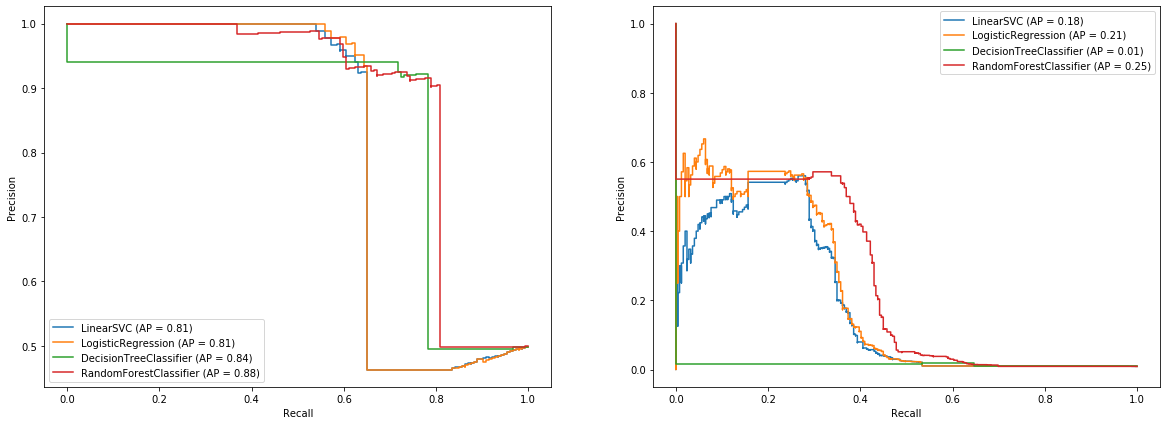

In [157]:
X = df_outer[features]
y = df_outer['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

svc, log_reg, d_tree, rf = trainData(X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_curve(ax = ax[0], X_test = X_test, y_test=y_test)

# Visualizing results on test_data
X_test, y_test = test_data[features], test_data['Label']
plot_curve(ax = ax[1], X_test = X_test, y_test=y_test)
plt.show()

# Takeaways 

**The major takeaways after modeling the data in raw form:**

- `SVM` and `Logistic Regression` algorithm performance was below than `Random Forest` 
    - Since SVM and Logistic work on distance between points. Therefore to improve the perfomance we need feature scaling.
- We should model the relation between the accounts.
    - For modeling relations b/w accounts, clustering is used. I am using K-Means clustering so that similar accounts fall into a cluster.
- It is better to use all features rather than using selected features.
- Removing accounts with all values 0 showed some significant impact.

# Feature Scaling

- For feature scaling, I am using StandardScaler()

In [228]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X = train_data[features]

standard_scaler = StandardScaler()
X_standard = standard_scaler.fit_transform(X)

# Clustering and Classification

In [246]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=10, random_state=4)
k_means_train = k_means.fit_predict(X_standard)

In [247]:
X_train = pd.DataFrame(data = X_standard, columns=features)
X_train = X_train.round(4)

In [248]:
cluster = pd.get_dummies(k_means_train, prefix='cluster')

In [249]:
X_train = pd.concat([X_train, cluster], axis = 1)
y_train = train_data['Label']

In [250]:
X_test = standard_scaler.transform(test_data[features]).round(4)
k_means_test = k_means.predict(X_test)
X_test = pd.DataFrame(data = X_test, columns=features)
cluster = pd.get_dummies(k_means_test, prefix='cluster')
X_test = pd.concat([X_test, cluster], axis = 1)

missing_columns_test = set(X_train.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0
y_test = test_data['Label']

C:\Users\eehvmvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



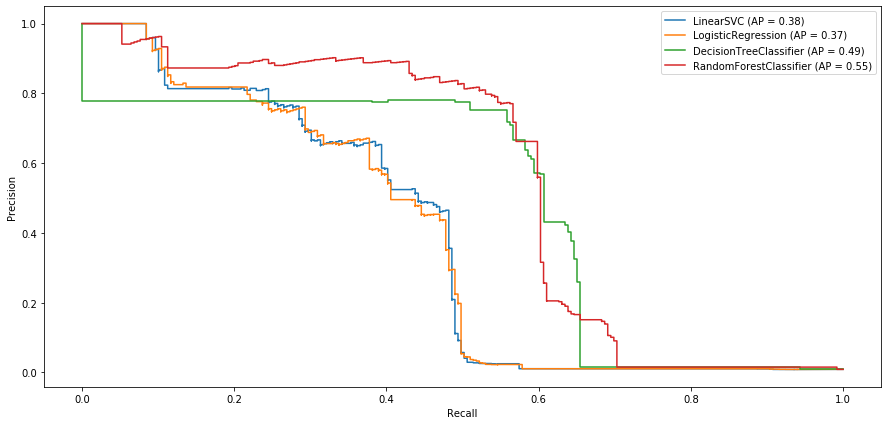

In [251]:
svc, log_reg, d_tree, rf = trainData(X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(figsize=(15, 7))
plot_curve(ax = ax, X_test = X_test, y_test=y_test)

- Clustring using 10 clusters and then running classification model on scaled data has improved the **Average Precision Score**.
- Since Random Forest has performed best in all cases. I will be choosing Random Forest as Classification aslgorithm

In [278]:

# Creating a function for determing the optimal number of clusters
def clustering_classification(n_cluster, X_train, X_test, y_train, y_test):
    k_means = KMeans(n_clusters=n_cluster, random_state=4)
    
    k_means_train = k_means.fit_predict(X_train)
    cluster_train = pd.get_dummies(k_means_train, prefix='cluster')
    X_train = pd.DataFrame(data = X_train, columns=features)
    X_train = pd.concat([X_train, cluster_train], axis = 1)
    
    k_means_test = k_means.predict(X_test)
    X_test = pd.DataFrame(data = X_test, columns=features)
    cluster_test = pd.get_dummies(k_means_test, prefix='cluster')
    X_test = pd.concat([X_test, cluster_test], axis = 1)

    missing_columns_test = set(X_train.columns) - set(X_test.columns)
    print(missing_columns_test)
    for col in missing_columns_test:
        X_test[col] = 0
    
    rf = RandomForestClassifier()
    
    rf.fit(X_train, y_train)
    
    y_scores = rf.predict_proba(X_test)[:, 1]
    
    avg_precsion = average_precision_score(y_test, y_scores)
    
    return rf, X_test, avg_precsion

In [272]:
X = train_data[features]

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X).round(4)

X_test = standard_scaler.transform(test_data[features]).round(4)


y_train = train_data['Label']
y_test = test_data['Label']

n_clusters_list = []
avg_precision_list = []

for n_cluster in range(1,31):
    print(n_cluster)
    rf, X_test, avg_precision = clustering_classification(n_cluster, X_train, X_test, y_train, y_test)
    n_clusters_list.append(n_cluster)
    avg_precision_list.append(avg_precision)

1
set()
2
{'cluster_1'}
3
{'cluster_2'}
4
{'cluster_3', 'cluster_1'}
5
{'cluster_3', 'cluster_4', 'cluster_1'}
6
{'cluster_3', 'cluster_5', 'cluster_4', 'cluster_1'}
7
{'cluster_6', 'cluster_3', 'cluster_4', 'cluster_1', 'cluster_5'}
8
{'cluster_7', 'cluster_4', 'cluster_1', 'cluster_2', 'cluster_5'}
9
{'cluster_3', 'cluster_8', 'cluster_4', 'cluster_1'}
10
{'cluster_3', 'cluster_4', 'cluster_9', 'cluster_5', 'cluster_2'}
11
{'cluster_6', 'cluster_1', 'cluster_10', 'cluster_9', 'cluster_2'}
12
{'cluster_3', 'cluster_4', 'cluster_9', 'cluster_5', 'cluster_2', 'cluster_11'}
13
{'cluster_3', 'cluster_4', 'cluster_9', 'cluster_5', 'cluster_2', 'cluster_11'}
14
{'cluster_6', 'cluster_10', 'cluster_1', 'cluster_9', 'cluster_12', 'cluster_2'}
15
{'cluster_3', 'cluster_4', 'cluster_13', 'cluster_9', 'cluster_5', 'cluster_2', 'cluster_11'}
16
{'cluster_6', 'cluster_3', 'cluster_8', 'cluster_1', 'cluster_10', 'cluster_2', 'cluster_5', 'cluster_11'}
17
{'cluster_15', 'cluster_11', 'cluster_16', '

In [273]:
max(avg_precision_list)

0.6079060509553307

In [274]:
avg_precision_list

[0.6079060509553307,
 0.6076644475624018,
 0.6071658347380576,
 0.6049103467638315,
 0.6057068609856614,
 0.6053602411800558,
 0.6060779038707765,
 0.6064757738526808,
 0.551141081624289,
 0.6004622713675672,
 0.6057249336324267,
 0.5975522913409945,
 0.5978323868881671,
 0.59559561121343,
 0.5967243651884647,
 0.6045434557587399,
 0.5881400190655565,
 0.5772913155857528,
 0.6033479028158456,
 0.6007229522907327,
 0.5941568238585375,
 0.5922093743365067,
 0.5931107809189019,
 0.5973077151305236,
 0.6027940869766257,
 0.5691890413458829,
 0.5810085136211097,
 0.5691719396548345,
 0.5688971112707948,
 0.5697451108308997]

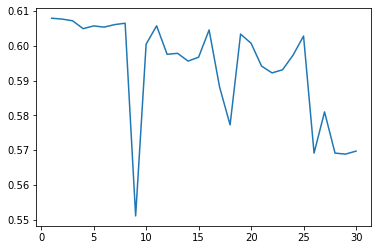

In [277]:
plt.plot(n_clusters_list, avg_precision_list)
plt.show()

- Pretty much as expected, most of the data is sparse with lot of 0s.
- The clusters are divided in such a way that, most of the rows align in 1 cluster.
- Cluster 1 is the optimum number of clusters

set()


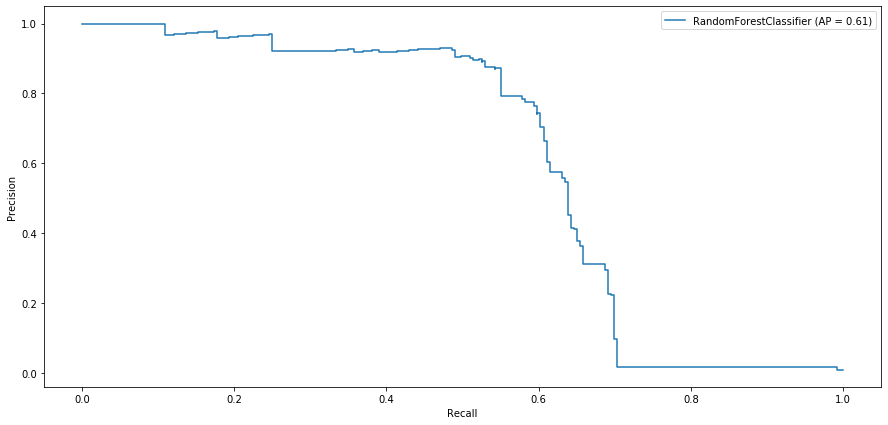

In [280]:
X = train_data[features]

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X).round(4)

X_test = standard_scaler.transform(test_data[features]).round(4)


y_train = train_data['Label']
y_test = test_data['Label']

rf, X_test, avg_precision = clustering_classification(1, X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(figsize=(15, 7))
plot_precision_recall_curve(rf, X_test, y_test, ax = ax)
plt.legend(loc='best', prop={'size': 10})
plt.show()    

- Going forward, we can use **sequence classification techiniques like RNN (I don't know how RNN works that's why I haven't tried it here)